In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
%matplotlib inline

# read in preprocessed data
json file has been processed using the data_extraction.py script to create the .csv file

In [2]:
df = pd.read_csv('data/ufodata_complete.csv', encoding='utf-8')

# Clean data

In [3]:
df['city'] = df['city'].str.replace(',','')

In [4]:
df['state'] = df['state'].str.lower()
states = ['wa', 'wi', 'wv', 'fl', 'wy', 'nh', 'nj', 'nm', 'na', 'nc', 'nd', 'ne', 'ny', 'ri', 'nv', 'gu', 'co', 'ca', 'ga', 'ct', 'ok', 'oh', 'ks', 'sc', 'ky', 'or', 'sd', 'de', 'dc', 'hi', 'pr', 'tx', 'la', 'tn', 'pa', 'va', 'vi', 'ak', 'al', 'as', 'ar', 'vt', 'il', 'in', 'ia', 'az', 'id', 'me', 'md', 'ma', 'ut', 'mo', 'mn', 'mi', 'mt', 'mp', 'ms']
df['state'] = df['state'].apply(lambda x: x if x in states else None)
df['occurred'] = pd.to_datetime(df['occurred'], errors='coerce')

- City looks clean, comma removed
- State cleaned up
- Shapes cleaned up


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136494 entries, 0 to 136493
Data columns (total 7 columns):
Unnamed: 0    136494 non-null int64
occurred      134505 non-null datetime64[ns]
city          136419 non-null object
state         119862 non-null object
shape         131747 non-null object
duration      130597 non-null object
desc          136492 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 7.3+ MB


In [10]:
shapes = df['shape'].unique()[:19]
df['shape'] = df['shape'].apply(lambda x: x if x in shapes else 'Unknown')

In [11]:
df['shape'].value_counts()

Light        27703
Unknown      18462
Circle       14556
Triangle     12567
Fireball     10955
Other         9154
Sphere        9030
Disk          7919
Oval          5912
Formation     4316
Changing      3263
Flash         2439
Rectangle     2266
Cylinder      2040
Diamond       1973
Chevron       1577
Teardrop      1203
Egg           1159
Name: shape, dtype: int64

In [12]:
df['shape'] = df['shape'].astype('str')
df['state'] = df['state'].astype('str')
shape_count = pd.DataFrame(df.groupby('shape')['Unnamed: 0'].count())

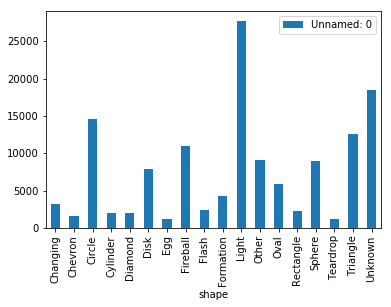

In [13]:
shape_count.plot(kind='bar')

In [14]:
def convert_to_string(x):
    try:
        return x.encode('utf-8', 'ignore').decode('ascii')
    except:
        return ''

In [15]:
df['desc'] = df['desc'].apply(lambda x: convert_to_string(x))

In [16]:
description = df['desc'].values

# Create a tfidf from the description

In [17]:
def build_text_vectorizer(contents, use_stemmer=False, max_features=None):
    '''
    Build and return a **callable** for transforming text documents to vectors,
    as well as a vocabulary to map document-vector indices to words from the
    corpus. The vectorizer will be trained from the text documents in the
    `contents` argument. If `use_tfidf` is True, then the vectorizer will use
    the Tf-Idf algorithm, otherwise a Bag-of-Words vectorizer will be used.
    The text will be tokenized by words, and each word will be stemmed iff
    `use_stemmer` is True. If `max_features` is not None, then the vocabulary
    will be limited to the `max_features` most common words in the corpus.
    '''
    Vectorizer = TfidfVectorizer
    tokenizer = RegexpTokenizer(r"[\w']+")
    stem = PorterStemmer().stem if use_stemmer else (lambda x: x)
    stop_set = set(stopwords.words('english'))

    # Closure over the tokenizer et al.
    def tokenize(text):
        tokens = tokenizer.tokenize(text)
        stems = [stem(token) for token in tokens if token not in stop_set]
        return stems

    vectorizer_model = Vectorizer(tokenizer=tokenize, max_features=max_features)
    vectorizer_model.fit(contents)
    vocabulary = np.array(vectorizer_model.get_feature_names())

    # Closure over the vectorizer_model's transform method.
    def vectorizer(X):
        return vectorizer_model.transform(X).toarray()

    return vectorizer, vocabulary

In [18]:
vect, vocab = build_text_vectorizer(description, use_stemmer=True, max_features=500)


In [19]:
tfidf = vect(description)

In [20]:
tfidf.shape

(136494, 500)

In [21]:
nmf = NMF(n_components=6, max_iter=100, alpha=0.00001)
W = nmf.fit_transform(tfidf)
H = nmf.components_

In [22]:
W.shape

(136494, 6)

In [40]:
def hand_label_topics(H, vocabulary):
    '''
    Print the most influential words of each latent topic, and prompt the user
    to label each topic. The user should use their humanness to figure out what
    each latent topic is capturing.
    '''
    hand_labels = []
    for i, row in enumerate(H):
        top_five = np.argsort(row)[::-1][:10]
        print 'topic', i
        print '-->', ' '.join(vocabulary[top_five])
        label = raw_input('please label this topic: ')
        hand_labels.append(label)
        print
    return hand_labels


In [41]:
hand_labels = hand_label_topics(H, vocab)

topic 0
--> look like see saw back time could go one ufo
please label this topic: comparisons

topic 1
--> provid inform anonym elect pd nuforc contact note remain total
please label this topic: anonymous

topic 2
--> light bright red flash white move sky green blue star
please label this topic: colours

topic 3
--> object move appear shape sky observ speed high travel cloud
please label this topic: movement

topic 4
--> craft shape fli triangl low triangular sound light aircraft hover
please label this topic: shape

topic 5
--> orang orb firebal ball disappear sky move glow east west
please label this topic: fire

